In [1]:
BATCH_SIZE = 1024

PAD_SIZE = 80
TARGET_LABELS = [
    "Improvement",
    "Solved",
    #"AreaRatio",
    #"Stacks"
]

SEED = 3093453

# Preprocessing

## Load Packages and Data

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Random Seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Cosmetics
np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    suppress=True
    )

sns.set(
    context="talk",
    style="darkgrid"
)


cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [3]:
import tensorflow as tf
from tensorflow import keras

train_samples = os.path.join(cwd, "data", "train") # 116586 + 489623 = 606209
val_samples = os.path.join(cwd, "data", "test")

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = train_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = train_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "validation",
    follow_links = False
)



Found 489623 files belonging to 1 classes.
Using 440661 files for training.


2024-02-17 14:19:28.150561: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-17 14:19:28.150596: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-17 14:19:28.150599: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-17 14:19:28.150795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-17 14:19:28.150814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 489623 files belonging to 1 classes.
Using 48962 files for validation.


In [4]:
for X in train_dataset.take(1):
    pass

df = pl.DataFrame({"raw": X.numpy().astype(str)})
print(df[0, 0])

dataset: B
instance: MA2
+-----------+
2D Packing MIP with Time Limit 15 [s] in Truck P355037001
Stack 0 with items: ['0090016200_26102022000265', '0090016200_26102022000255']
Stack 1 with items: ['0090016200_26102022012372', '0090016200_26102022012372', '0090016200_26102022017816']
Stack 2 with items: ['0090016200_26102022006635', '0090016200_26102022002470', '0090016200_26102022013378']
Stack 3 with items: ['0090016200_26102022015271', '0090016200_26102022007589', '0090016200_26102022015271']
Stack 4 with items: ['0090016200_26102022001327', '0090016200_26102022001327']
Stack 5 with items: ['0090016200_26102022015678', '0090016200_26102022004493', '0090016200_26102022015678']
Stack 6 with items: ['0090016200_26102022019753', '0090016200_26102022019604', '0090016200_26102022019753']
Stack 7 with items: ['0090016200_26102022016002', '0090016200_26102022016002', '0090016200_26102022016002']
Stack 8 with items: ['0090016200_26102022012624', '0090016200_26102022012624', '0090016200_261020

## Loading CSVs

In [5]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident", # drop because of rename earlier
    # Unnecassary columns
    "Product code",
    "Package",
    "Plant code",
    "Product code",
    "Package code",
    "NestedHeight"
]).unique()

items.collect()

Supplier code,Supplier dock,Plant dock,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth
i64,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool
2671602,null,"""169GD-60""",1.6,1.2,0.93,0.38658,0.045,"""C""","""BY""","""0090016900_270…",false,false
22060301,null,"""169GB-10""",1.6,1.2,0.93,0.405136,0.045,"""C""","""BY""","""0090016900_270…",false,false
1925700,null,"""GRF1""",1.2,1.0,0.975,0.1463,0.045,"""C""","""BY""","""0090016900_270…",false,false
2573225,null,"""GRF1""",0.78,0.57,0.478,0.04088,0.047,"""C""","""BY""","""0090016900_270…",false,true
22060301,null,"""169GB-10""",1.2,1.0,0.93,0.62582,0.045,"""C""","""BY""","""0090016900_270…",false,false
6681302,null,"""169GD-60""",1.206,1.01,1.093,0.08744,0.0,"""C""","""BY""","""0090016900_270…",false,false
90016100,"""K11""","""GRD1""",2.3,1.6,1.0,1.57,0.045,"""C""","""BY""","""0090016900_270…",false,false
1925700,null,"""GRF1""",1.209,1.007,0.75,0.098141,0.025,"""C""","""BY""","""0090016900_270…",false,false
22060301,null,"""169GB-30""",3.2,1.2,1.49,0.605548,0.045,"""C""","""BY""","""0090016900_270…",false,false


In [6]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)
truck_stops.collect()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
62069600,1,null,1,"""X3""",1,"""P187730501""","""A""","""AS"""
62069600,1,null,1,"""X1""",1,"""P188730503""","""A""","""AS"""
62069600,1,null,1,"""X1""",1,"""P188730505""","""A""","""AS"""
62059600,1,null,1,"""X0""",1,"""P189731001""","""A""","""AS"""
62059600,1,null,1,"""X0""",1,"""P190731053""","""A""","""AS"""
28091900,1,null,1,"""X4""",1,"""P192708201""","""A""","""AS"""
29918200,1,null,1,"""X2""",1,"""P192717701""","""A""","""AS"""
29918200,1,null,1,"""X1""",2,"""P192717701""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P193730403""","""A""","""AS"""


In [7]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
              "EMmm", "EMmr"
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
    (pl.col("EMmm") / 1000),
    (pl.col("EMmr") / 1000),
])

truck_dims.collect()

truck_id,Length,Width,Weight,EMmm,EMmr,dataset,instance
str,f64,f64,f64,f64,f64,str,str
"""P187730405""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P187730503""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P187731305""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P188730501""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189706801""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189721701""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189730407""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P190731053""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P192730507""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""


## Preprocessing Functions:

In [8]:
import sys
sys.path.append("..")

from utils.preprocessing import input_output_generation

In [9]:
cx, cy = input_output_generation(
    X,
    target_labels=TARGET_LABELS,
    pad_size=PAD_SIZE,
    shuffle=False,
    items=items,
    truck_stops=truck_stops,
    truck_dims=truck_dims,
)

In [10]:
cx[0][0, :40]

array([[ 1.2       ,  1.        ,  0.37984   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.424516  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.577192  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.252146  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.377846  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.206     ,  1.01      ,  0.2851    ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.42000008],
       [ 1.206     ,  1.01      ,  0.3985    ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.42000008],
       [ 1.206     ,  1.01      ,  0.07856   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.420

# DNN

In [11]:
loss_solved = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=2,
    alpha = cy[0].mean(),
    name='solved_focal_loss'
)

loss_improvement = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=1.5,
    alpha = cy[1].mean(),
    name='improvement_focal_loss'
)

loss_area_ratio = tf.keras.losses.BinaryCrossentropy(
    name='area_ratio_crossentropy'
)



loss_stacks = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=6,
    alpha = cy[-1].mean(),
    name='stacks_focal_loss'
)

for i, target in enumerate(TARGET_LABELS):
    print(f"{target} Prevalence: {cy[i].mean():.1%}")

Improvement Prevalence: 46.6%
Solved Prevalence: 37.9%


In [12]:
target_loss_objects = {
    "Solved": loss_solved,
    "Improvement": loss_improvement,
    "AreaRatio": loss_area_ratio,
    "Stacks": loss_stacks,
}

loss_objects = [target_loss_objects[target] for target in TARGET_LABELS]
mean_losses = [tf.keras.metrics.Mean(name=target) for target in TARGET_LABELS]

In [13]:
all_target_metrics: list[list[tf.keras.metrics]] = {
    "Solved": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "Improvement": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "AreaRatio": [
        keras.metrics.RootMeanSquaredError(name="RMSE"),
        keras.metrics.MeanAbsoluteError(name="MAE")
    ],
    "Stacks": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
}

all_metrics = [all_target_metrics[target] for target in TARGET_LABELS]

In [14]:
from keras import backend as K
#model_path = os.path.join(cwd, "models", "FinalModelTraining-Train+Val-11.tf")
model_path = os.path.join(cwd, "models", "FinalModelTraining-Train+Val-21.tf")
model = tf.keras.models.load_model(model_path)
model

In [15]:
N_FEATURES = cx[0].shape[-1]

n_blocks=6
num_heads=4

# Learning Rate
initial_lr = 10e-3 # 10e-3
lr_decay = 0.9995

# Optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = initial_lr)

### Model Architecture Inspection:

In [16]:
_ = model(cx) # just check if it works
model.summary()

2024-02-17 14:20:08.498870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 StackLevelInputFeatures (I  [(None, 80, 9)]              0         []                            
 nputLayer)                                                                                       
                                                                                                  
 MaskingLayer (Masking)      (None, 80, 9)                0         ['StackLevelInputFeatures[0][0
                                                                    ]']                           
                                                                                                  
 transformer_encoder (Trans  ((None, 80, 9),              613       ['MaskingLayer[0][0]']        
 formerEncoder)               (None, 4, 80, 80))                                              

## Helper Functions

In [17]:
def print_status_bar(iteration, total, losses, all_metrics=None, training:bool=True):
    tabs = "\t\t\t\t\t\t\t\t\t\t\t\t\t\t"
    metrics = tabs.join([
        f"{TARGET_LABELS[i]:<12}\tLoss: {losses[i].result():.4f}" +
        "\t".join([
            f"{m.name:>10}: {m.result():.2%}"
            if m.name not in ["MAE", "RMSE"]
            else f"{m.name:>10}: {m.result():.4f}"
            for m in metrics
        ])
        for i, metrics in enumerate(all_metrics)
    ])
    
    if training:
        prefix="Training"
    else:
        prefix="Validation"
    
    print(f"\r{prefix}-Iteration: {iteration+1:0>3}/{total:<3}\tLR: {float(optimizer.lr):<1000.9f}" + metrics,
          end="")


In [18]:
@tf.function
def model_pass(model, inputs, targets, training):
    """
    Usual Tensorflow model passing of inputs throught the network.
    If in training mode, the optimizier can apply the gradients
    observed with GradientTape to the model parameters
    """
    
    with tf.GradientTape() as tape:
        
        outputs = model(inputs, training=training)

        # Single output is not a list!
        if type(outputs) != list:
            outputs = [outputs]
            
        losses = [l(t, o) for l,o,t in zip(loss_objects, outputs, targets)]
        
        if training:
            gradients = tape.gradient(losses, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        for i, mean_loss in enumerate(mean_losses):
            if len(mean_losses) <= 1:
                mean_loss(losses)
            else:
                mean_loss(losses[i])
        
    return outputs


In [19]:
def run_epoch(model, dataset, target_labels, all_metrics:list[list[tf.keras.metrics]],
              epoch:int, history:pd.DataFrame, training:bool=True,
              shuffle:bool=True):
    """
    Single epoch, running several training steps over a dataset
    """

    for step, X_batch in enumerate(dataset):
        
        X_batch, y_batch = input_output_generation(
            X_batch,
            items=items,
            truck_stops=truck_stops,
            truck_dims=truck_dims,
            target_labels=target_labels,
            shuffle=shuffle,
            pad_size=PAD_SIZE
        )
        
        outputs = model_pass(model, X_batch, y_batch, training=training)
        
        for i, metrics in enumerate(all_metrics):
            for metric in metrics:
                metric(y_batch[i].reshape(-1), outputs[i].numpy().reshape(-1))
    
        print_status_bar(step, len(dataset), mean_losses, all_metrics, training=training)
    
        #### LEARNING RATE UPDATE ####
        if training:
            optimizer.lr = geometric_decay((epoch-1)*len(dataset)+step, initial_lr, lr_decay)
    
    print("\n")

    #### UPDATE METRICS
    for i, metrics in enumerate(all_metrics):
        for metric in metrics:
            data = pd.DataFrame({
                "Epoch": [epoch],
                "Target": [target_labels[i]],
                "Metric": [metric.name if training else f"Val-"+metric.name],
                "Value": [float(metric.result())],
            })
            history = pd.concat([history, data])
            metric.reset_states()

    for i, mean_loss in enumerate(mean_losses):
        data = pd.DataFrame({
            "Epoch": [epoch],
            "Target": [target_labels[i]],
            "Metric": ["Loss" if training else f"Val-"+"Loss"],
            "Value": [float(mean_loss.result())],
        })
        history = pd.concat([history, data])
        mean_loss.reset_states()
            
    return model, history

# Test Set Performance

In [20]:
val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = val_samples,
    labels = None,
    batch_size = 10_000,
    max_length = None,
    shuffle = True,
    seed = SEED,
    follow_links = False
)

Found 104591 files belonging to 1 classes.


In [21]:
val_track = run_epoch(model, val_dataset, TARGET_LABELS, all_metrics, epoch=0, history=None, training=False, shuffle=True)
val_track

Validation-Iteration: 011/11 	LR: 0.010000000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

(<keras.src.engine.functional.Functional at 0x2b03b66d0>,
    Epoch       Target    Metric     Value
 0      0  Improvement   Val-PRC  0.809144
 0      0  Improvement   Val-SNS  0.796568
 0      0  Improvement   Val-AUC  0.898310
 0      0  Improvement   Val-ACC  0.821858
 0      0       Solved   Val-PRC  0.875923
 0      0       Solved   Val-SNS  0.795453
 0      0       Solved   Val-AUC  0.929768
 0      0       Solved   Val-ACC  0.875668
 0      0  Improvement  Val-Loss  0.136215
 0      0       Solved  Val-Loss  0.075412)

# Compare the relationship between solved and inproved instances

In [22]:
for X_val_raw in val_dataset:
    X_val, y_val = input_output_generation(
            X_val_raw,
            items=items,
            truck_stops=truck_stops,
            truck_dims=truck_dims,
            target_labels=TARGET_LABELS,
            shuffle=False,
            pad_size=PAD_SIZE
        )
    break

X_val_raw = X_val_raw.numpy().astype(str)
print(X_val_raw[0])

dataset: X
instance: AS5
+-----------+
2D Packing MIP with Time Limit 15 [s] in Truck P215770405
Stack 0 with items: ['0090018000_14062023014054', '0090018000_14062023014054', '0090018000_14062023014054']
Stack 1 with items: ['0090018000_14062023014054', '0090018000_14062023014054', '0090018000_14062023014054']
Stack 2 with items: ['0090018000_14062023014054', '0090018000_14062023014054', '0090018000_14062023014054']
Stack 3 with items: ['0090018000_14062023014054', '0090018000_14062023013456', '0090018000_14062023013456']
Stack 4 with items: ['0090018000_14062023013456', '0090018000_14062023013456', '0090018000_14062023013456']
Stack 5 with items: ['0090018000_14062023013456', '0090018000_14062023013456', '0090018000_14062023013456']
Stack 6 with items: ['0090018000_14062023013456', '0090018000_14062023009500', '0090018000_14062023009500']
Stack 7 with items: ['0090018000_14062023009950', '0090018000_14062023009950', '0090018000_14062023009950']
Stack 8 with items: ['0090018000_140620

In [23]:
X_val[0][0,:25]

array([[1.2      , 1.       , 0.426732 , 0.       , 0.       , 2.       , 0.       , 0.0999999, 0.5      ],
       [1.2      , 1.       , 0.426732 , 0.       , 0.       , 2.       , 0.       , 0.0999999, 0.5      ],
       [1.2      , 1.       , 0.426732 , 0.       , 0.       , 2.       , 0.       , 0.0999999, 0.5      ],
       [1.2      , 1.       , 0.426732 , 0.       , 0.       , 2.       , 0.       , 0.0999999, 0.5      ],
       [1.2      , 1.       , 0.426732 , 0.       , 0.       , 2.       , 0.       , 0.0999999, 0.5      ],
       [1.2      , 1.       , 0.426732 , 0.       , 0.       , 2.       , 0.       , 0.0999999, 0.5      ],
       [1.2      , 1.       , 0.426732 , 0.       , 0.       , 2.       , 0.       , 0.0999999, 0.5      ],
       [1.2      , 1.       , 0.4302   , 0.       , 0.       , 1.       , 0.       , 0.0999999, 0.5      ],
       [1.2      , 1.       , 0.4302   , 0.       , 0.       , 1.       , 0.       , 0.0999999, 0.5      ],
       [1.2      , 1.       

## Model prediction Quality:

In [24]:
y_pred_improvement, y_pred_solved = model(X_val)
y_pred_improvement, y_pred_solved = y_pred_improvement.numpy(), y_pred_solved.numpy()

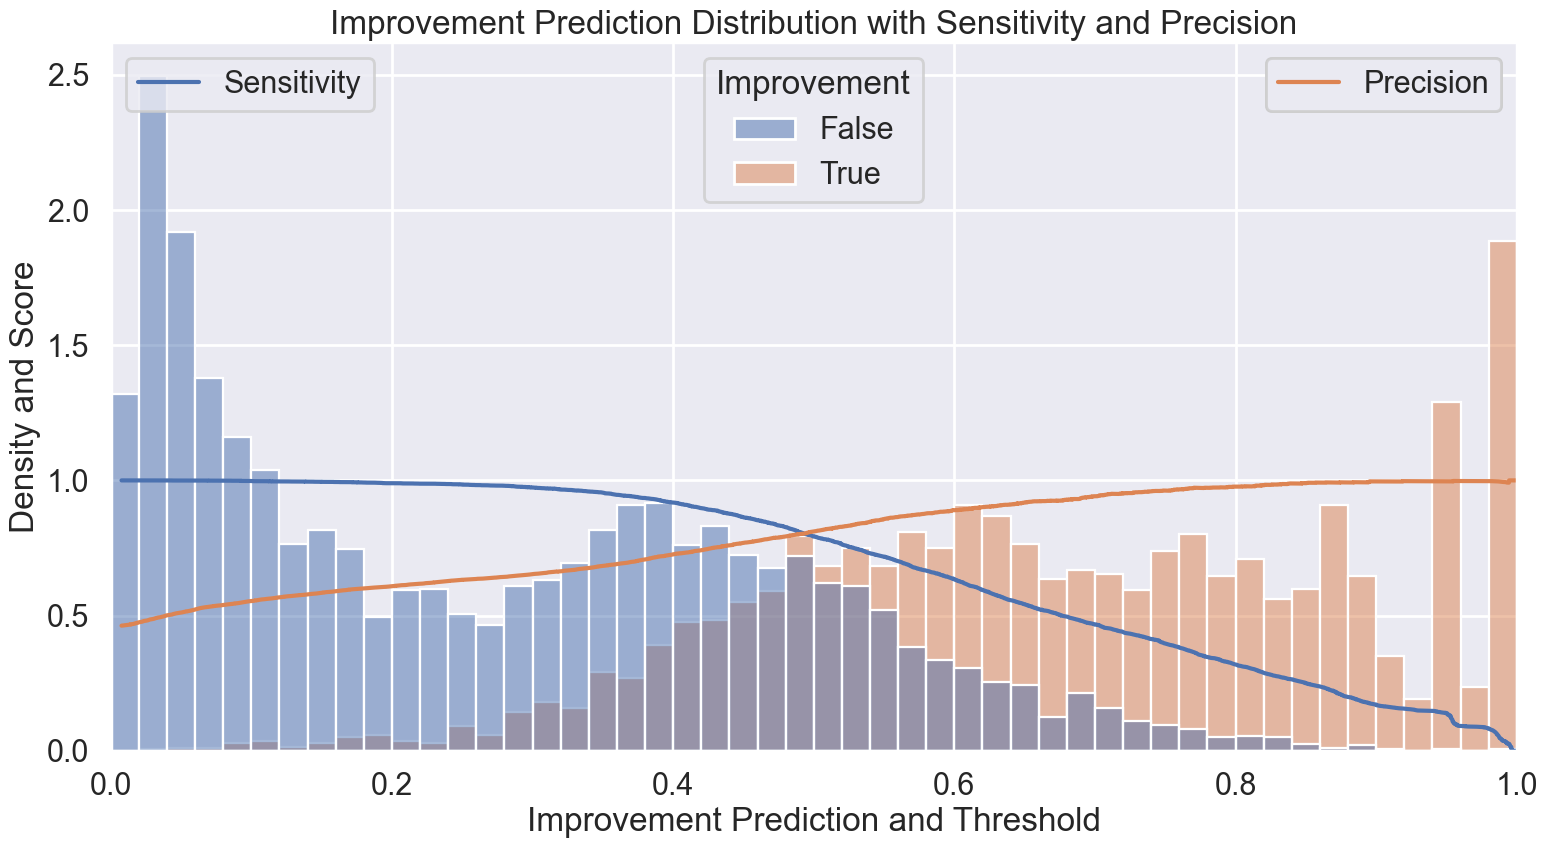

In [25]:
from sklearn.metrics import precision_recall_curve

sns.set(context="poster")

pred_df = pd.DataFrame([y_pred_improvement, y_val[0].astype(bool)]).T
pred_df.columns = ["Prediction", "Improvement"]

prec, sens, thrsh = precision_recall_curve(y_val[0], y_pred_improvement, drop_intermediate=False, pos_label=True)
thrsh = np.append(thrsh, 1)

fig, ax = plt.subplots(figsize=(16, 9))



g = sns.histplot(
    data=pred_df,
    x="Prediction",
    hue="Improvement",
    bins=np.arange(0, 1.02, 0.02),
    stat="density",
    ax=ax,
);
sns.move_legend(g, "upper center")
legend=ax.get_legend()


sens_curve = ax.plot(thrsh, sens, label="Sensitivity");
prec_curve = ax.plot(thrsh, prec, label="Precision");
#ax.legend();

ax.set(
    title="Improvement Prediction Distribution with Sensitivity and Precision",
    xlabel="Improvement Prediction and Threshold",
    ylabel="Density and Score",
    xlim=[0, 1],
);

#hist_legend = ax.legend(handles=hist, loc='upper right');
sens_legend = ax.legend(handles=sens_curve, loc='upper left')
prec_legend = ax.legend(handles=prec_curve, loc='upper right')

ax.add_artist(sens_legend)
ax.add_artist(prec_legend)
ax.add_artist(legend);

plt.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-01-13-Model-Inference", f"ImprovementPredictionDistribution-Train+Val.{file_format}")
    plt.savefig(path)


#first_legend = ax.legend(handles=[line1], loc='upper right')

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


def specificity(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

for threshold in np.arange(0, 1, 0.1):
    y_pred_improvement_bool = (y_pred_improvement > threshold)
    print(f"Threshold: {threshold:.1f}", end = "\t\t")
    for metric in [specificity, recall_score, precision_score, f1_score, accuracy_score]:
        print(f"{metric.__name__.split('_')[0]}: {metric(y_val[0], y_pred_improvement_bool):.1%}", end="\t\t")
    print()

Threshold: 0.0		specificity: 0.0%		recall: 100.0%		precision: 46.3%		f1: 63.3%		accuracy: 46.3%		
Threshold: 0.1		specificity: 30.8%		recall: 99.8%		precision: 55.4%		f1: 71.2%		accuracy: 62.7%		
Threshold: 0.2		specificity: 45.2%		recall: 98.9%		precision: 60.8%		f1: 75.3%		accuracy: 70.0%		
Threshold: 0.3		specificity: 55.5%		recall: 97.4%		precision: 65.3%		f1: 78.2%		accuracy: 74.9%		
Threshold: 0.4		specificity: 70.2%		recall: 91.8%		precision: 72.6%		f1: 81.1%		accuracy: 80.2%		
Threshold: 0.5		specificity: 84.1%		recall: 79.3%		precision: 81.1%		f1: 80.2%		accuracy: 81.8%		
Threshold: 0.6		specificity: 93.2%		recall: 63.4%		precision: 89.0%		f1: 74.0%		accuracy: 79.4%		
Threshold: 0.7		specificity: 97.5%		recall: 46.7%		precision: 94.2%		f1: 62.5%		accuracy: 74.0%		
Threshold: 0.8		specificity: 99.3%		recall: 31.9%		precision: 97.7%		f1: 48.1%		accuracy: 68.1%		
Threshold: 0.9		specificity: 99.9%		recall: 17.1%		precision: 99.6%		f1: 29.2%		accuracy: 61.6%		


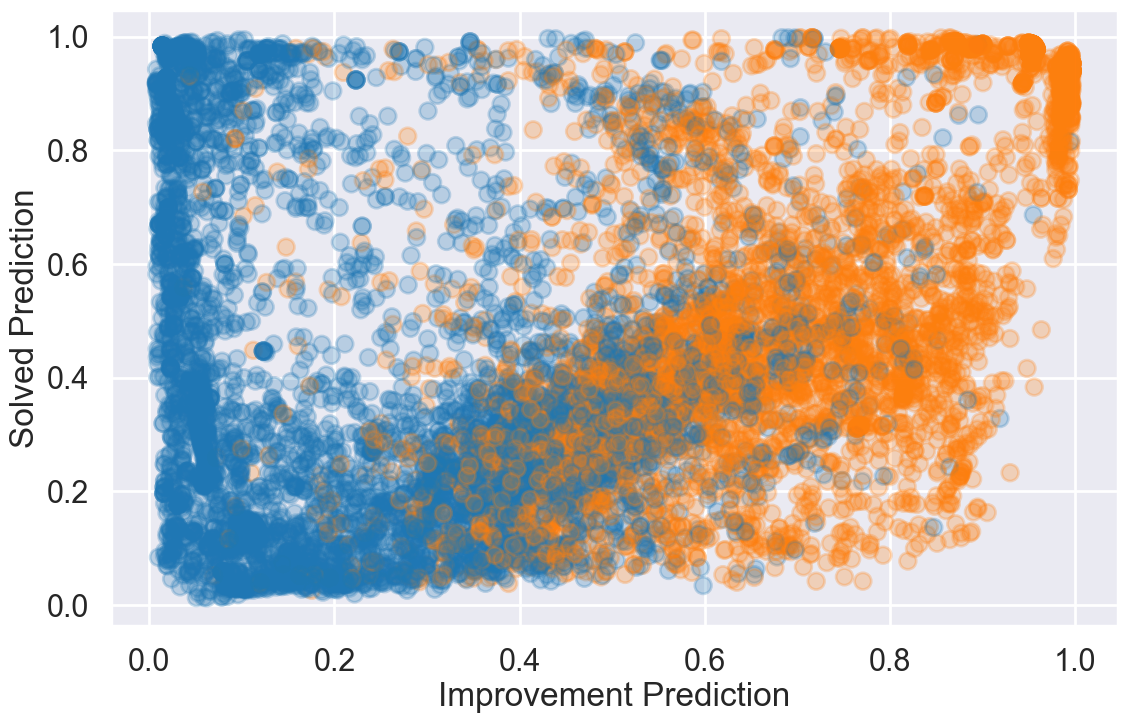

In [27]:
plt.figure(figsize=(13, 8))
plt.scatter(
    y_pred_improvement,
    y_pred_solved,
    c=["tab:orange" if y_improvement else "tab:blue" for y_improvement in y_val[0]],
    alpha = 0.25);
plt.ylabel("Solved Prediction")
plt.xlabel("Improvement Prediction");

# Visualize Attention Matrix:

In [28]:
from utils.DNN.utils import get_attention_scores

attention = get_attention_scores(model, model_inputs=X_val, layer_name=f"transformer_encoder_5")
attention.shape

(10000, 4, 80, 80)

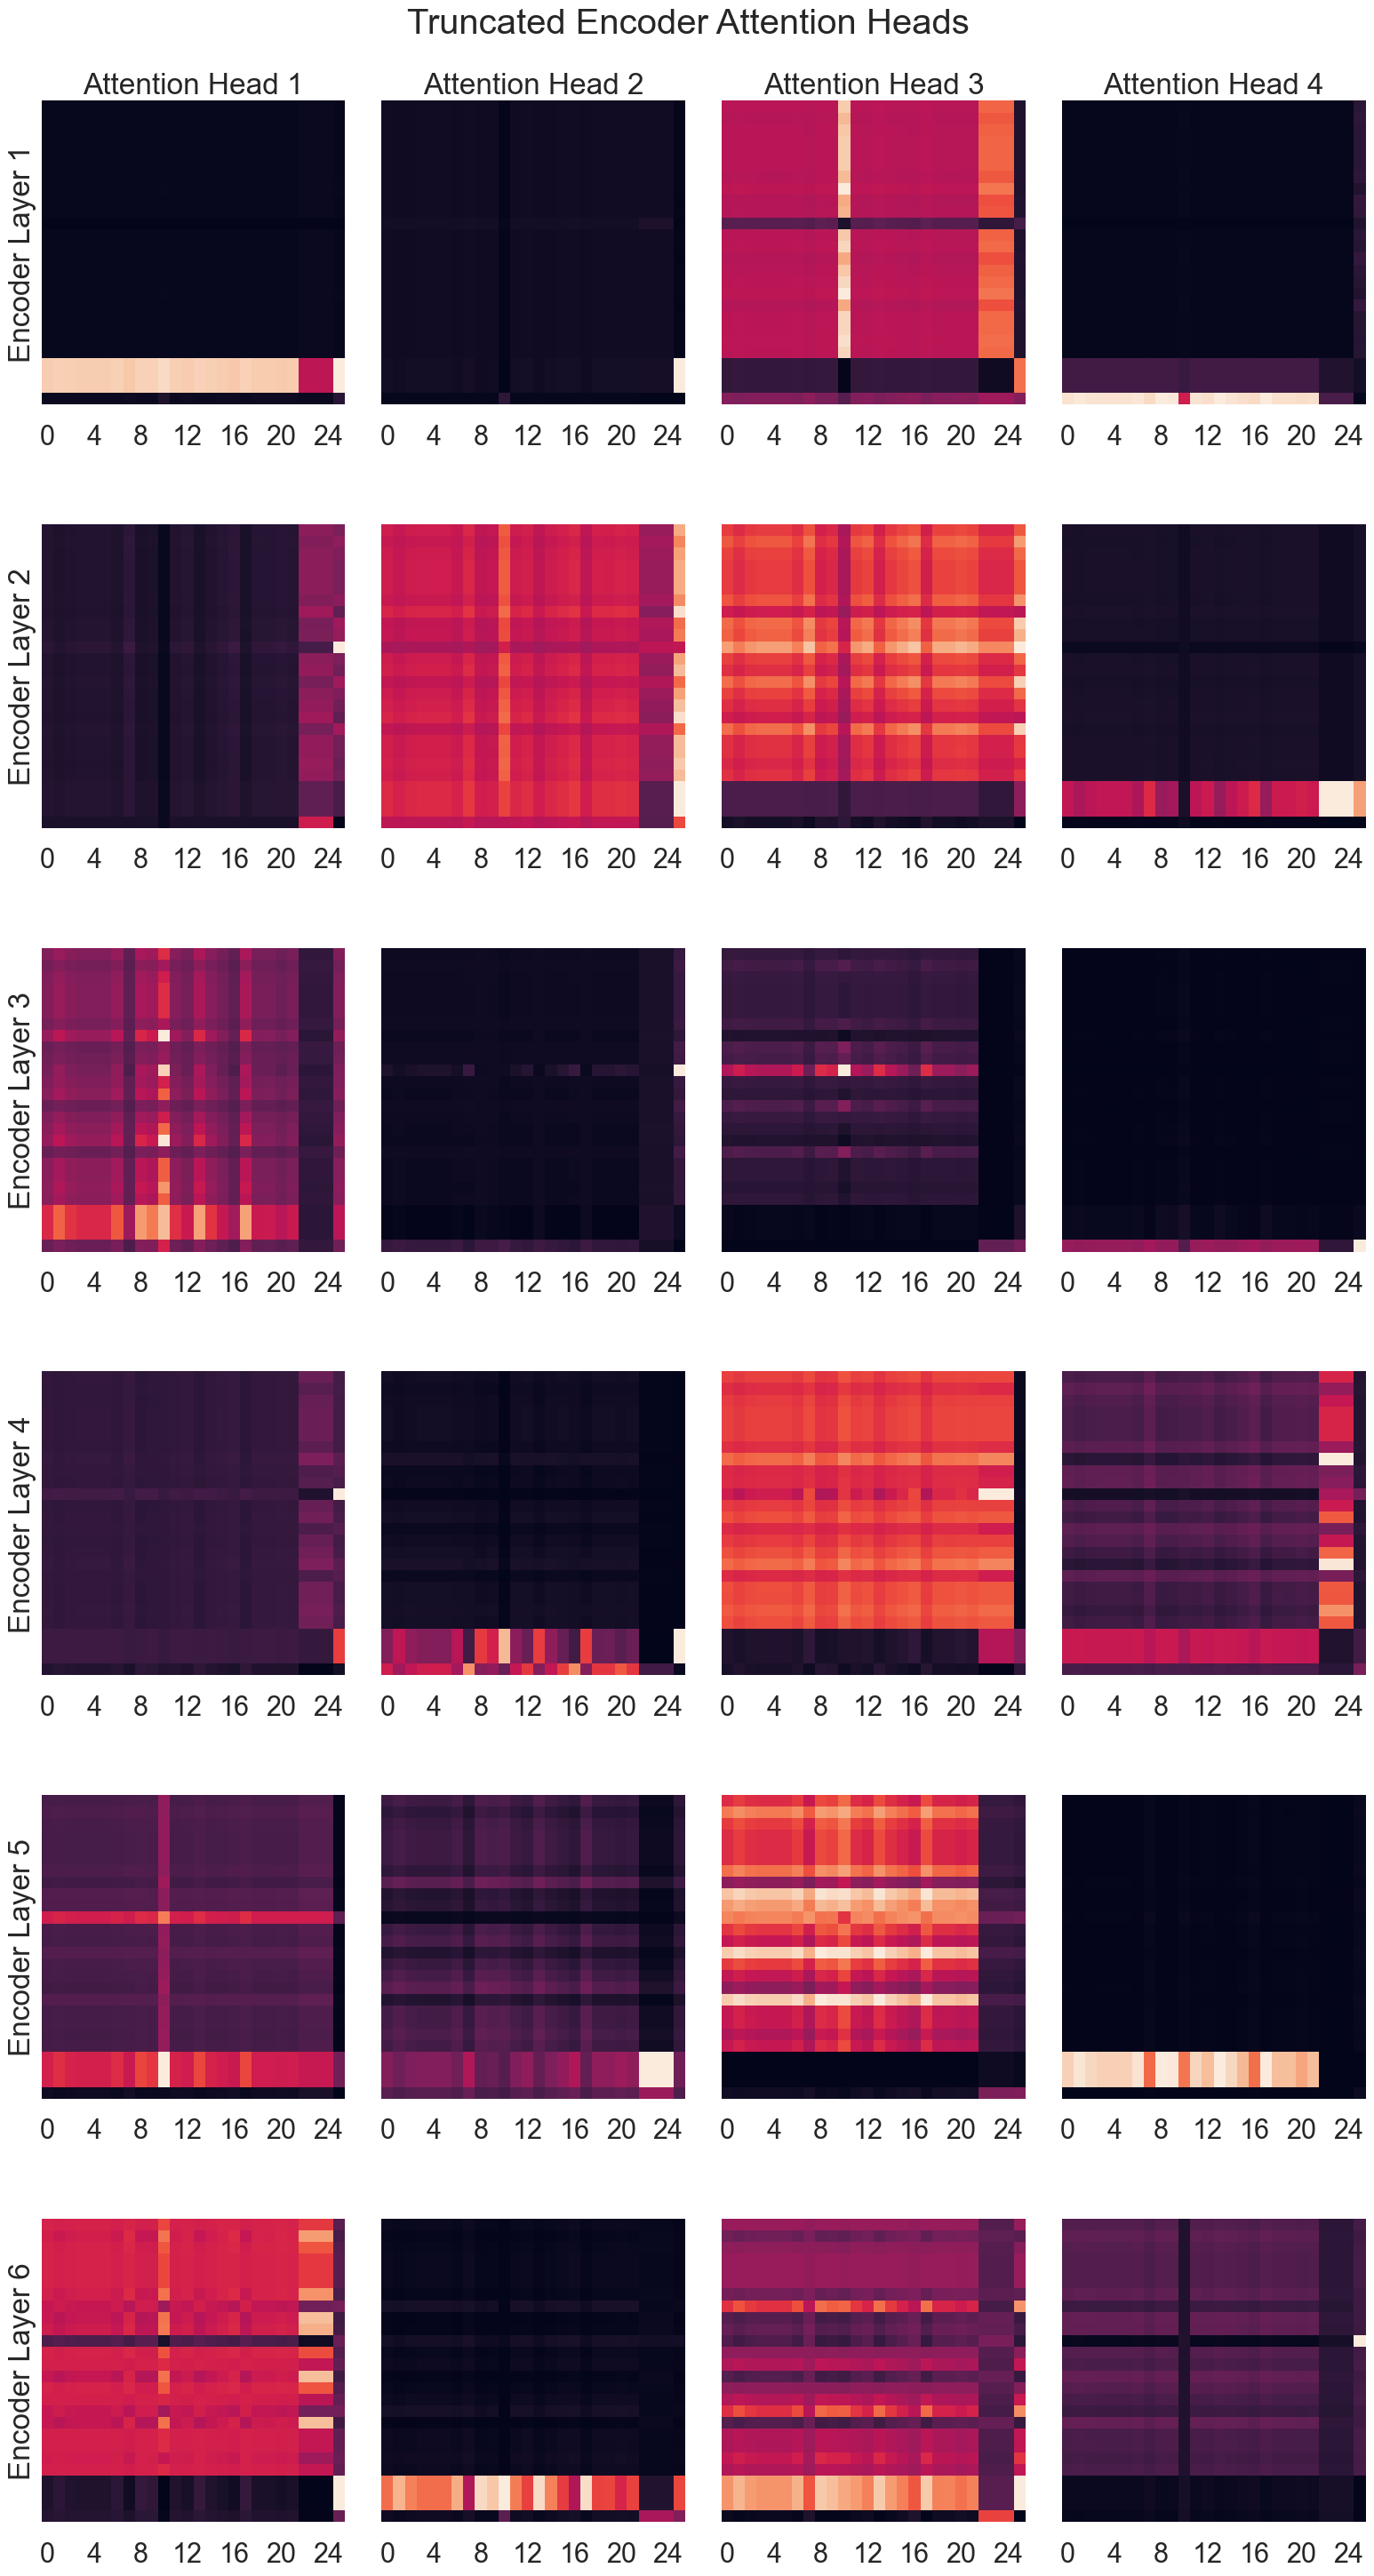

In [29]:
example_index = 2
n_inputs = np.argmax(np.all(X_val[0][example_index].round(2) == 0, axis=1))


num_layers = 6
num_heads = 4

fig, ax = plt.subplots(num_layers, num_heads, figsize=(16, num_layers*5))

for encoder_layer in range(num_layers):
    
    encoder_layer_name = f"transformer_encoder_{encoder_layer}" if encoder_layer else f"transformer_encoder"
    attention = get_attention_scores(model, model_inputs=X_val, layer_name=encoder_layer_name)
    
    for head in range(num_heads):
        attention_matrix = attention[example_index, head, :n_inputs, :n_inputs]
        sns.heatmap(
            attention_matrix.T,
            square=True,
            cbar=False,
            vmin=0,
            #vmax=0.1,
            ax=ax[encoder_layer, head],
            yticklabels=[]
        );

        
    
    ax[encoder_layer, 0].set(
        ylabel=f"Encoder Layer {encoder_layer+1}"
    )
for head in range(num_heads):
    ax[0, head].set(
        title=f"Attention Head {head+1}"
    )

fig.suptitle("Truncated Encoder Attention Heads")

plt.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-01-13-Model-Inference", f"AttentionExample-Train+Val.{file_format}")
    plt.savefig(path)


In [30]:
print(X_val_raw[example_index])

dataset: X
instance: CI5
+-----------+
2D Packing MIP with Time Limit 30 [s] in Truck P171447821
Stack 0 with items: ['0090016800_14062023023855', '0090016800_14062023008251', '0090016800_14062023008251', '0090016800_14062023008251']
Stack 1 with items: ['0090016800_14062023008612', '0090016800_14062023004233', '0090016800_14062023004233', '0090016800_14062023008612']
Stack 2 with items: ['0090016800_14062023023855', '0090016800_14062023023855', '0090016800_14062023023855', '0090016800_14062023023855']
Stack 3 with items: ['0090016800_14062023042782', '0090016800_14062023042782', '0090016800_14062023042782']
Stack 4 with items: ['0090016800_14062023042782', '0090016800_14062023038353', '0090016800_14062023038113']
Stack 5 with items: ['0090016800_14062023036779', '0090016800_14062023036718', '0090016800_14062023036718']
Stack 6 with items: ['0090016800_14062023036718', '0090016800_14062023036718', '0090016800_14062023036718']
Stack 7 with items: ['0090016800_14062023036718', '009001680

In [31]:
X_val[0][example_index,:50]

array([[ 1.2       ,  1.        ,  0.449472  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.429664  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.444548  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.449472  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.449472  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.449472  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.43208   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.479896  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.440